<a href="https://colab.research.google.com/github/VitalyGladyshev/NeuroN/blob/master/HW_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ_08

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Flatten, Dense, BatchNormalization, MaxPool2D, Activation, MaxPooling2D
# from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras import optimizers

from IPython.display import Image, display

from typing import List, Tuple

In [2]:
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [3]:
# MNIST 
batch_size = 64
(x_train, _), (x_test, _) = fashion_mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), <matplotlib.image.AxesImage at 0x7f6ab03fff28>)

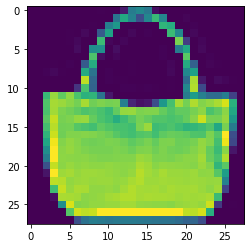

In [4]:
x_train.shape, plt.imshow(x_train[100])

## Discriminator

In [5]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

## Generator

In [6]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0 

In [7]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в текзор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [31]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epochs == epoch+1:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            
            plt.figure(figsize=(20,20))
            for i in range(self.num_img):
                ax = plt.subplot(self.num_img,self.num_img,i+1)
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                plt.imshow(img)
                plt.axis('off')
                img.save(f"generated_ep_{epoch+1}_img_{i}.png")
            plt.show()

Epoch 1/25
1094/1094 [==============================] - 19s 17ms/step - d_loss: 0.4255 - g_loss: 1.8040
Epoch 2/25
1094/1094 [==============================] - 19s 17ms/step - d_loss: 0.2691 - g_loss: 2.2645
Epoch 3/25
1094/1094 [==============================] - 19s 17ms/step - d_loss: 0.3616 - g_loss: 2.4024
Epoch 4/25
1094/1094 [==============================] - 18s 17ms/step - d_loss: 0.3650 - g_loss: 1.8164
Epoch 5/25
1094/1094 [==============================] - 18s 17ms/step - d_loss: 0.3692 - g_loss: 1.9241
Epoch 6/25
1094/1094 [==============================] - 19s 17ms/step - d_loss: 0.3391 - g_loss: 2.0524
Epoch 7/25
1094/1094 [==============================] - 18s 17ms/step - d_loss: 0.2737 - g_loss: 2.1383
Epoch 8/25
1094/1094 [==============================] - 18s 17ms/step - d_loss: 0.3314 - g_loss: 2.0907
Epoch 9/25
1094/1094 [==============================] - 18s 17ms/step - d_loss: 0.1437 - g_loss: 3.2668
Epoch 10/25
1094/1094 [==============================] - 18s 17m

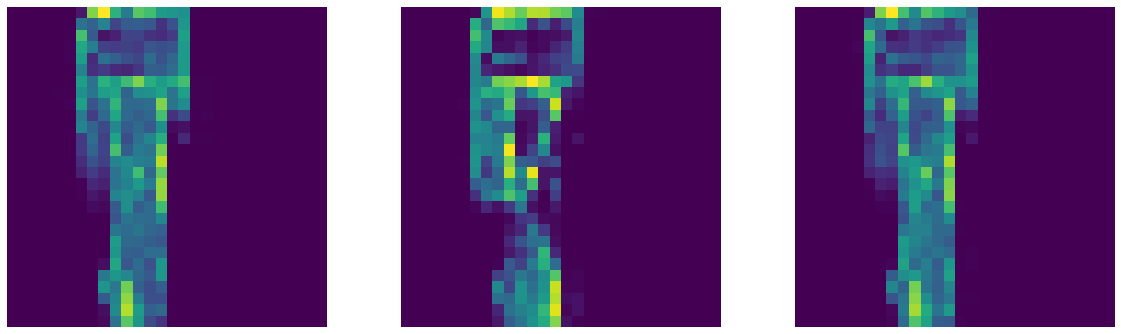

In [24]:
epochs = 25

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

hist = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

In [25]:
# for i in range(3):
#     display(Image(f"generated_ep_{epochs-1}_img_{i}.png"))

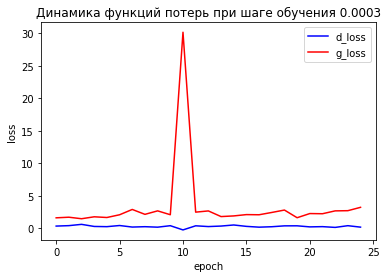

In [28]:
plt.plot(hist.history['d_loss'], 'b')
plt.plot(hist.history['g_loss'], 'r')
plt.title("Динамика функций потерь при шаге обучения 0.0003")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(labels=["d_loss", "g_loss"])
plt.show()

# Попытка улучшения

In [29]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = keras.Sequential([
                keras.Input(shape=(28, 28, 1)),
                layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.GlobalMaxPooling2D(),
                layers.Dense(1)], name="discriminator")
        self.generator = keras.Sequential([
                keras.Input(shape=(latent_dim,)),
                # строим размер входного вектора 7x7x128 map
                layers.Dense(7 * 7 * 128),
                layers.LeakyReLU(alpha=0.2),
                layers.Reshape((7, 7, 128)),
                layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")], name="generator")
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в текзор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

GAN: learning rate 0.0003, эпох 20

	Итерация: 1


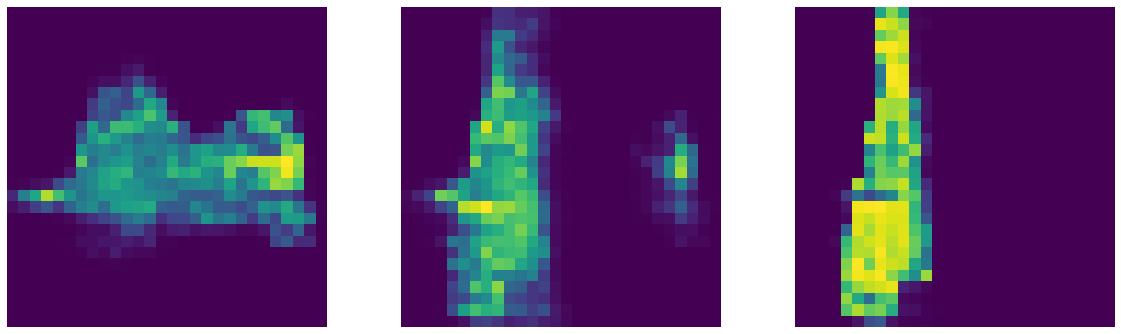

	Итерация: 2


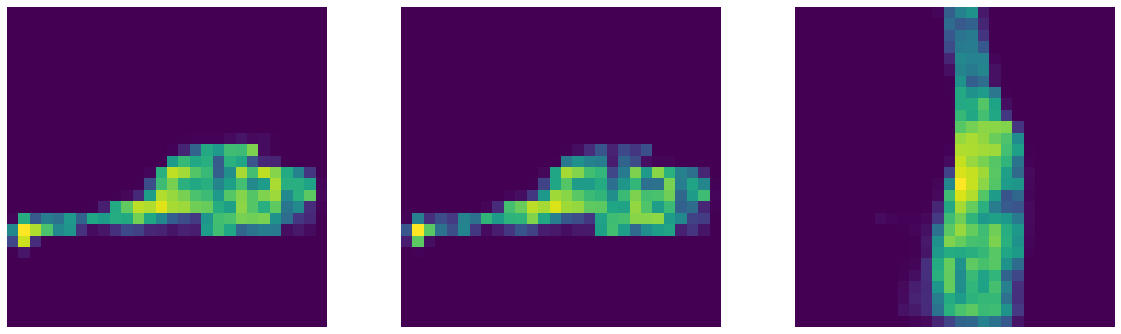

	Итерация: 3


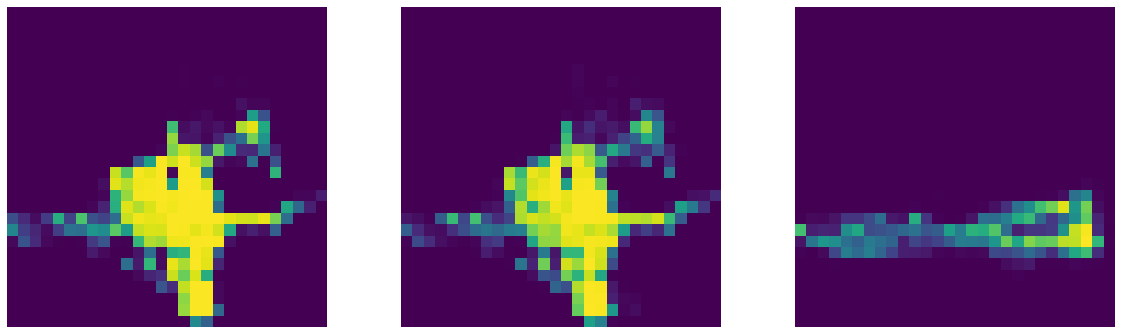

	Итерация: 4


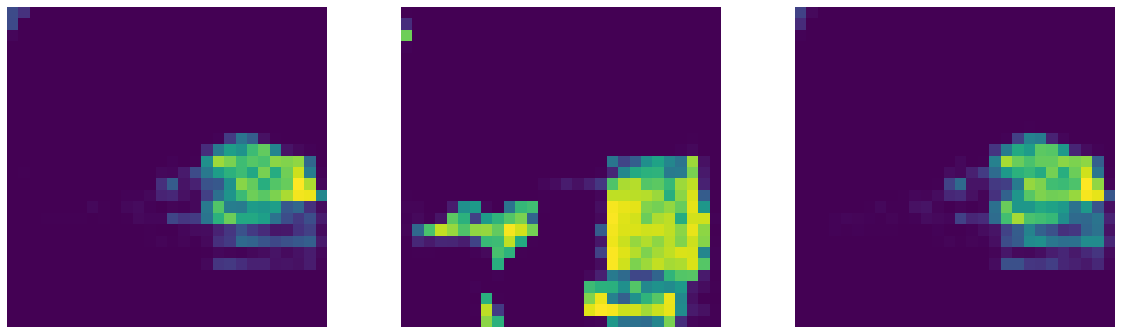

	Итерация: 5


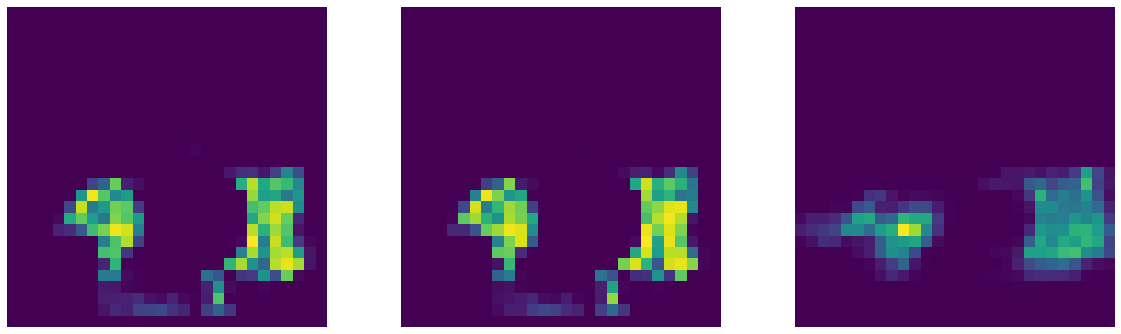

vr_d_loss. Средняя: 0.4015262339822948 список: [0.5125031841918826, 0.4728217222727835, 0.37665028423070906, 0.3578664295375347, 0.28778954967856407]
Ошибки на valid. Средняя: 2.2433457630872726 список: [1.4375899881124496, 3.393594565987587, 1.9730750173330307, 1.9563320696353912, 2.4561371743679046]
Дисперсия ошибки d_loss: 0.006571990977001031
Дисперсия ошибки g_loss: 0.4346035996866262
Доверительный интервал g_loss: 0.4346035996866262 - 0.4346035996866262




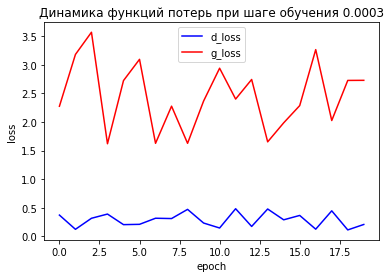

GAN: learning rate 0.0001, эпох 20

	Итерация: 1


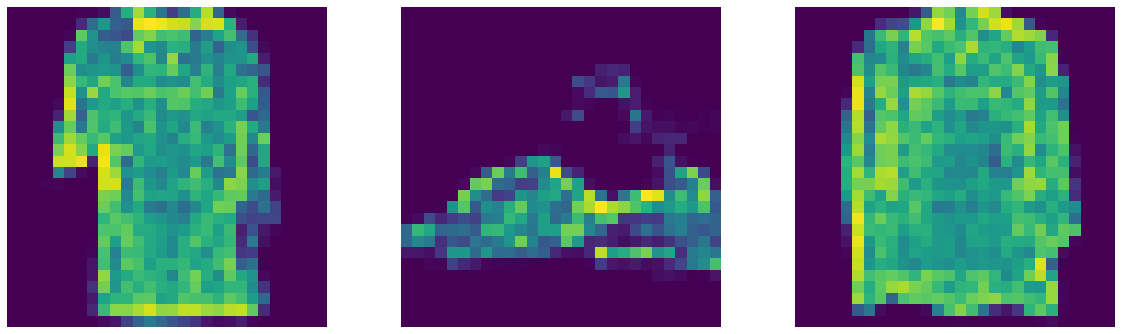

	Итерация: 2


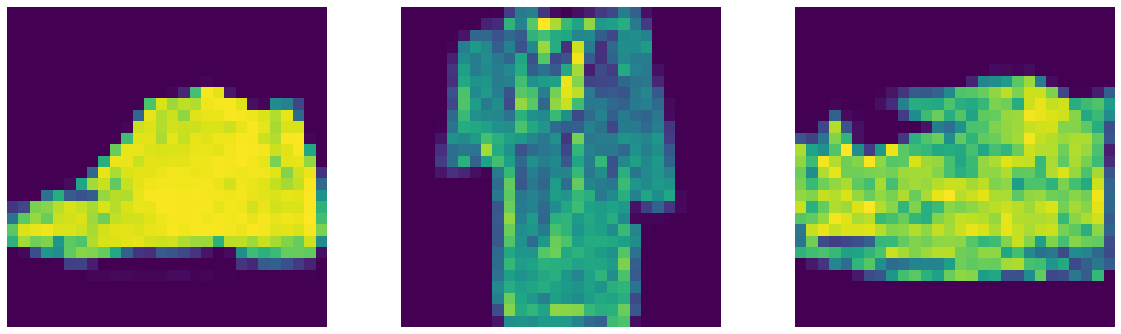

	Итерация: 3


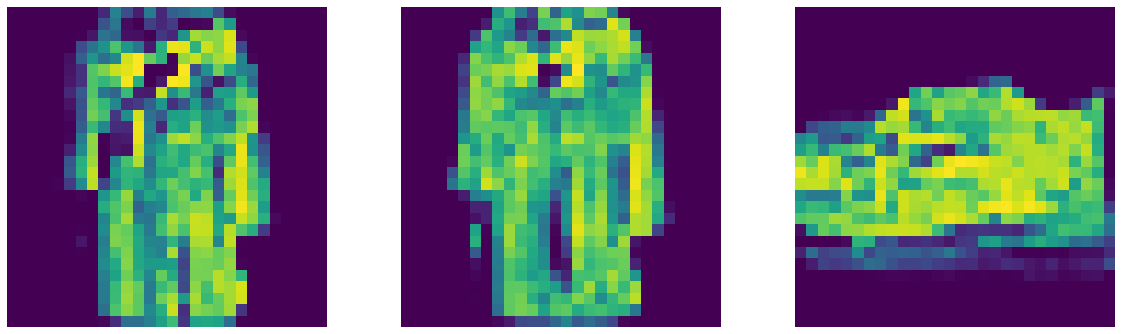

	Итерация: 4


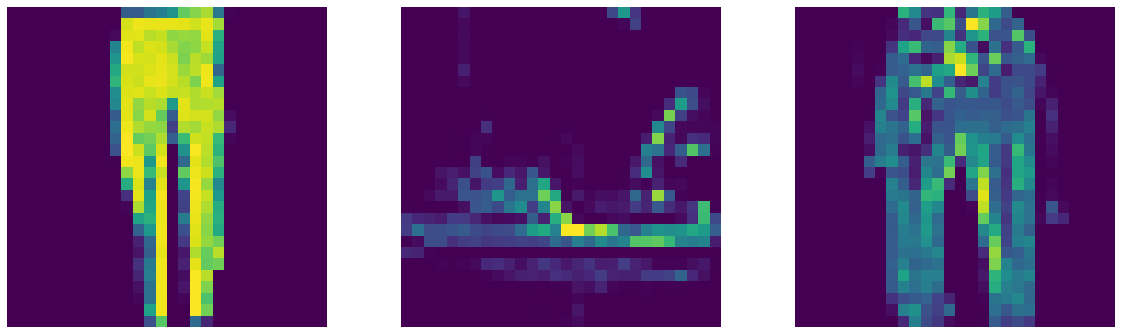

	Итерация: 5


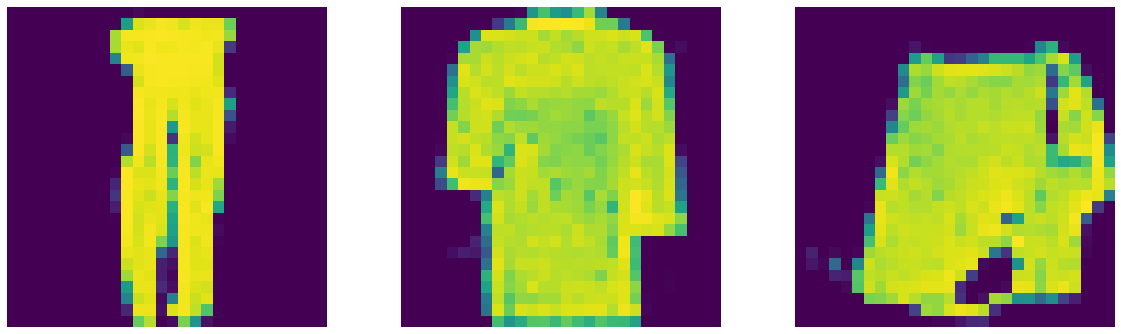

vr_d_loss. Средняя: 0.6393306189775467 список: [0.610932245850563, 0.6503042161464692, 0.6577109068632125, 0.6500593483448028, 0.6276463776826858]
Ошибки на valid. Средняя: 0.8554619592428206 список: [0.9093427568674087, 0.8345607340335846, 0.8294546037912369, 0.8375156939029693, 0.8664360076189042]
Дисперсия ошибки d_loss: 0.00030326990846349616
Дисперсия ошибки g_loss: 0.000891776456580603
Доверительный интервал g_loss: 0.000891776456580603 - 0.000891776456580603




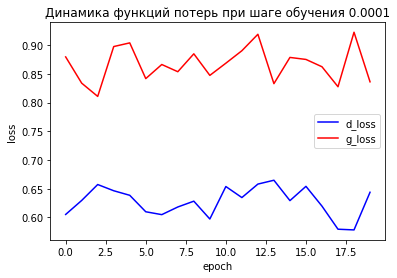

GAN: learning rate 5e-05, эпох 20

	Итерация: 1


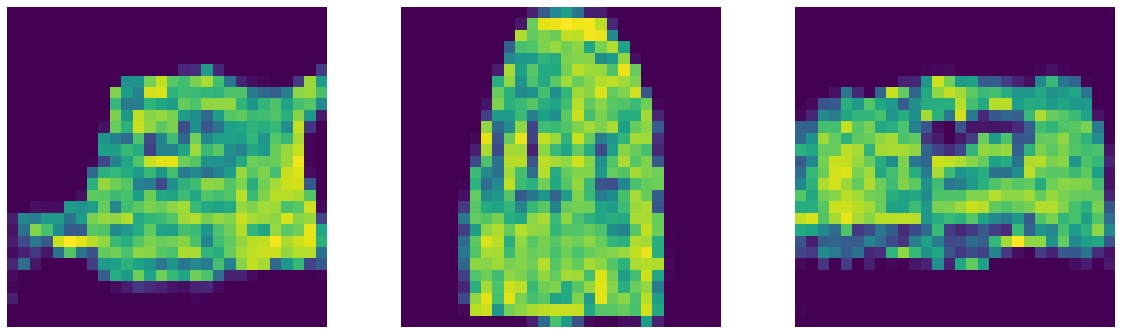

	Итерация: 2


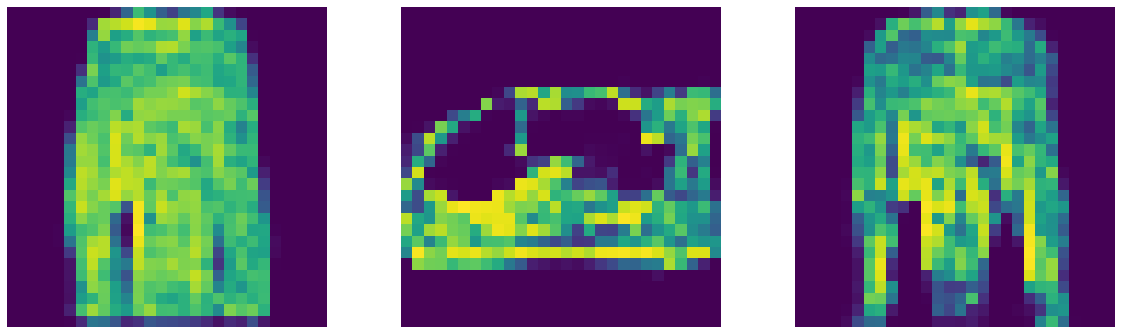

	Итерация: 3


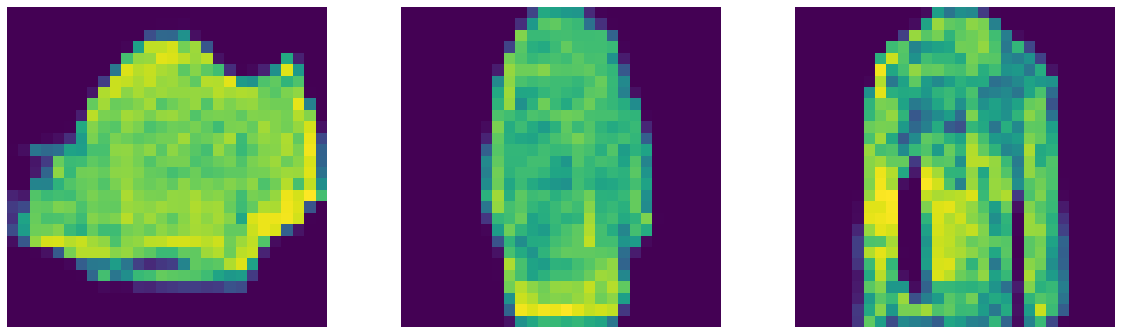

	Итерация: 4


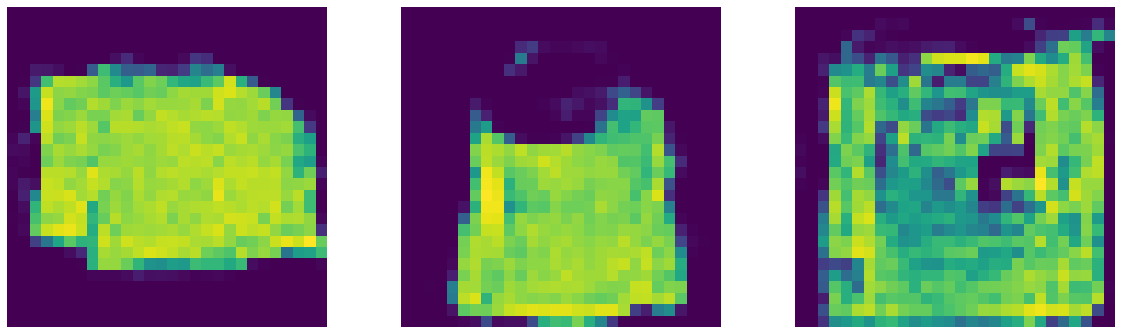

	Итерация: 5


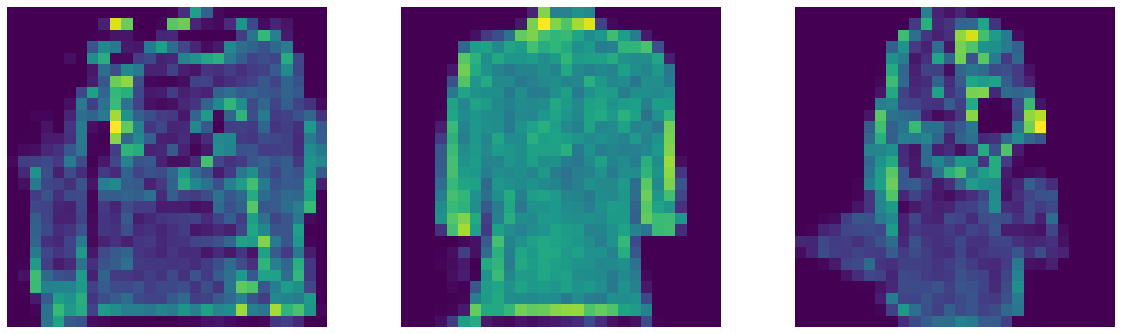

vr_d_loss. Средняя: 0.6401740801334381 список: [0.6132052689790726, 0.638399088382721, 0.6538841098546981, 0.6476401925086975, 0.6477417409420013]
Ошибки на valid. Средняя: 0.8551448172330856 список: [0.9258736968040466, 0.868877699971199, 0.8244707375764847, 0.8370634853839874, 0.8194384664297104]
Дисперсия ошибки d_loss: 0.00020628892197324878
Дисперсия ошибки g_loss: 0.0015467887371145364
Доверительный интервал g_loss: 0.0015467887371145364 - 0.0015467887371145364




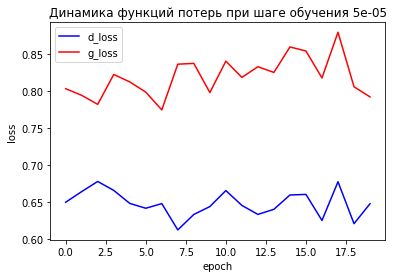

GAN: learning rate 1e-05, эпох 20

	Итерация: 1


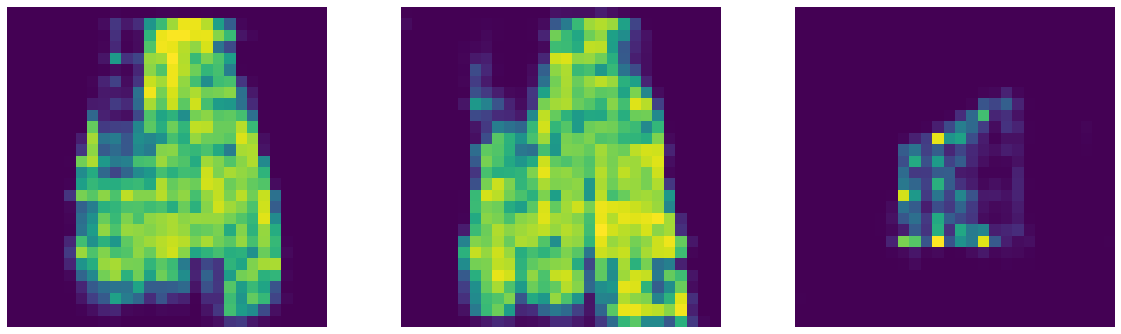

	Итерация: 2


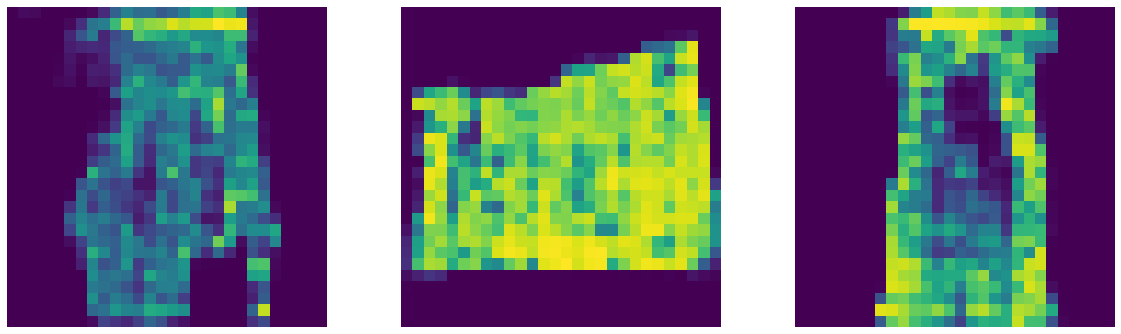

	Итерация: 3


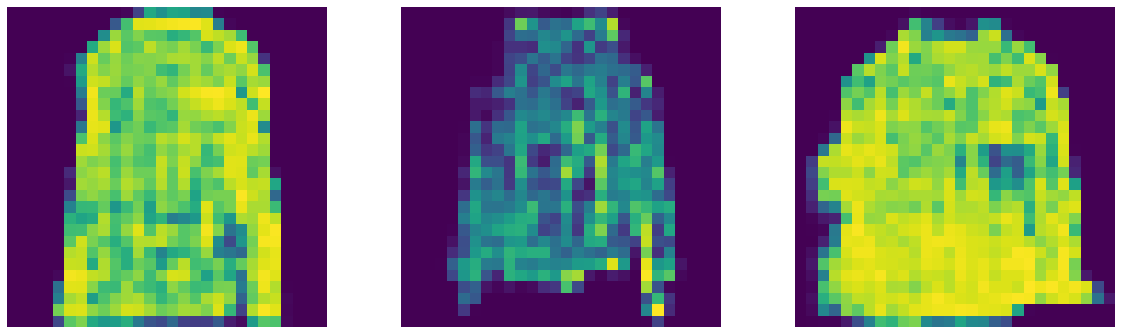

	Итерация: 4


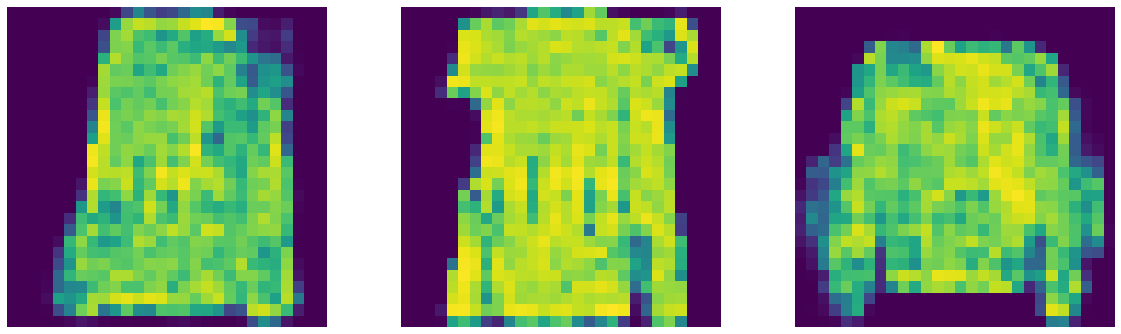

	Итерация: 5


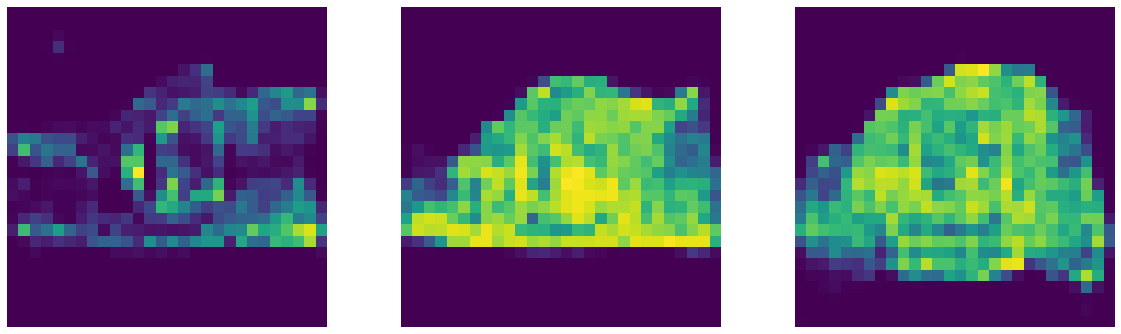

vr_d_loss. Средняя: 0.5768869024515153 список: [0.6178554013371468, 0.5683356925845147, 0.5704557806253433, 0.561562466621399, 0.5662251710891724]
Ошибки на valid. Средняя: 0.9360261738300324 список: [0.8627751231193542, 0.9541066497564316, 0.9355261951684952, 0.9655897080898285, 0.9621331930160523]
Дисперсия ошибки d_loss: 0.0004282822536457326
Дисперсия ошибки g_loss: 0.0014496898054629564
Доверительный интервал g_loss: 0.0014496898054629564 - 0.0014496898054629564




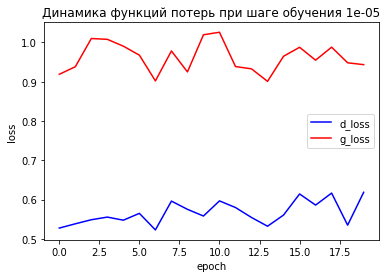

In [34]:
summary_data = pd.DataFrame(data=[[0, 0, 0, 0, 0, 0, 0]], 
                            columns=['learning_rate', 
                                     'mean_d_loss', 
                                     'mean_g_loss', 
                                     'vr_d_loss', 
                                     'vr_g_loss', 
                                     'l_vr_g', 
                                     'r_vr_g'])
cnt = 0
l_r = [0.0003, 0.0001, 0.00005, 0.00001]
epochs = 20
latent_dim = 128
num_img = 3

hist = {}

for fl_r in l_r:
    d_loss = []
    g_loss = []
    print(f"GAN: learning rate {fl_r}, эпох {epochs}\n")
    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=fl_r),
        g_optimizer=keras.optimizers.Adam(learning_rate=fl_r),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )
    for i in range(5):
        print(f"\tИтерация: {i+1}")
        hist = gan.fit(
            dataset, 
            epochs=epochs, 
            callbacks=[GANMonitor(num_img=num_img, latent_dim=latent_dim)], 
            verbose=0)
        d_loss.append(np.mean(hist.history['d_loss']))
        g_loss.append(np.mean(hist.history['g_loss']))
        # for i in range(3):
        #     display(Image(f"generated_ep_{epochs-1}_img_{i}.png"))

    vr_d_loss = np.var(d_loss)
    vr_g_loss = np.var(g_loss)
    l_g, r_g = calculate_confidence_interval(g_loss)
    mean_d_loss, mean_g_loss = np.mean(d_loss), np.mean(g_loss)
    print(f"vr_d_loss. Средняя: {mean_d_loss} список: {d_loss}")
    print(f"Ошибки на valid. Средняя: {mean_g_loss} список: {g_loss}")
    print(f"Дисперсия ошибки d_loss: {vr_d_loss}")
    print(f"Дисперсия ошибки g_loss: {vr_g_loss}")
    print(f"Доверительный интервал g_loss: {l_g} - {r_g}\n\n")
    summary_data.loc[cnt, ['learning_rate', 
                           'mean_d_loss', 
                           'mean_g_loss', 
                           'vr_d_loss', 
                           'vr_g_loss', 
                           'l_vr_g', 
                           'r_vr_g']] = [fl_r, 
                            mean_d_loss, mean_g_loss, vr_d_loss, vr_g_loss, 
                            l_g, r_g]
    plt.plot(hist.history['d_loss'], 'b')
    plt.plot(hist.history['g_loss'], 'r')
    plt.title(f"Динамика функций потерь при шаге обучения {fl_r}")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(labels=["d_loss", "g_loss"])
    plt.show()
    cnt += 1

In [35]:
summary_data

,learning_rate,mean_d_loss,mean_g_loss,vr_d_loss,vr_g_loss,l_vr_g,r_vr_g
0,0.00030,0.401526,2.243346,0.006572,0.434604,0.434604,0.434604
1,0.00010,0.639331,0.855462,0.000303,0.000892,0.000892,0.000892
2,0.00005,0.640174,0.855145,0.000206,0.001547,0.001547,0.001547
3,0.00001,0.576887,0.936026,0.000428,0.001450,0.001450,0.001450


In [36]:
summary_data.sort_values('mean_g_loss', ascending=True)

,learning_rate,mean_d_loss,mean_g_loss,vr_d_loss,vr_g_loss,l_vr_g,r_vr_g
2,0.00005,0.640174,0.855145,0.000206,0.001547,0.001547,0.001547
1,0.00010,0.639331,0.855462,0.000303,0.000892,0.000892,0.000892
3,0.00001,0.576887,0.936026,0.000428,0.001450,0.001450,0.001450
0,0.00030,0.401526,2.243346,0.006572,0.434604,0.434604,0.434604


# Результаты

Большое влияние на значене метрики оказывает подбор (снижение) шага обучения (learning rate). Лучший результат (по метрике) при использовании шага обучения 0.00005.

Фунуция ошибки демонстрирует быстрое насыщение и мало изменяется при увеличении числа эпох (нет динамики в обучении).

Отмечается некотарая разница в динамике обучения при одинаковом шаге обучения для дискриминатора и генератора (дискриминатор обучается быстрее). Возможно необходмо задавать разные значеня скорости обученя для генератора и дискриминатора.